# Nuclear Plant Simulation with Constant Heat Source

This notebook demonstrates running the nuclear plant simulator with a constant heat source instead of complex reactor physics. This is perfect for:

- Testing secondary side systems
- Development and debugging
- Understanding plant dynamics without reactor complexity
- Educational purposes

## Key Features

✅ **Instant Response**: Heat source responds immediately to power commands  
✅ **Predictable Behavior**: No complex reactor physics or dynamics  
✅ **Easy Control**: Simple power setpoint control  
✅ **Full Plant Model**: Complete thermal hydraulics and steam cycle  

## Setup and Imports

In [21]:
import sys
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from typing import List, Dict, Any
import time
from datetime import datetime

# Add project root to path
sys.path.append('..')
sys.path.append('../simulator')
sys.path.append('../systems')
sys.path.append('../core')

# Import nuclear simulator components
from core.sim import NuclearPlantSimulator, ControlAction
from systems.primary.reactor.heat_sources import ReactorHeatSource, ConstantHeatSource
from systems.primary.reactor.reactivity_model import create_equilibrium_state

#from utils.plant_data_logger import PlantDataLogger
#from utils.plant_plotter import PlantPlotter

# Configure matplotlib for better plots
plt.style.use('default')
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 10

print("✅ All imports successful!")
print(f"📅 Notebook started at: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")

✅ All imports successful!
📅 Notebook started at: 2025-06-11 19:51:02


## Create Constant Heat Source Simulator

Let's create a nuclear plant simulator using a constant heat source instead of reactor physics.

In [22]:
# Create constant heat source
heat_source = ConstantHeatSource(rated_power_mw=3000.0)

# Create simulator with constant heat source
simulator = NuclearPlantSimulator(heat_source=heat_source, dt=1.0, enable_secondary=True)

print("🔥 Heat Source Configuration:")
print(f"   Type: {heat_source.__class__.__name__}")
print(f"   Rated Power: {heat_source.rated_power_mw:.0f} MW")
print(f"   Current Power: {heat_source.get_power_percent():.1f}%")
#print(f"   Efficiency: {heat_source.get_efficiency():.1%}")

print("\n🏭 Simulator Configuration:")
print(f"   Time Step: {simulator.dt:.1f} seconds")
print(f"   Initial Power Level: {simulator.state.power_level:.1f}%")
print(f"   Initial Fuel Temperature: {simulator.state.fuel_temperature:.1f}°C")
print(f"   Initial Coolant Temperature: {simulator.state.coolant_temperature:.1f}°C")
print(f"   Initial Control Rod Position: {simulator.state.control_rod_position:.1f}%")

🔥 Heat Source Configuration:
   Type: ConstantHeatSource
   Rated Power: 3000 MW
   Current Power: 100.0%

🏭 Simulator Configuration:
   Time Step: 1.0 seconds
   Initial Power Level: 100.0%
   Initial Fuel Temperature: 575.0°C
   Initial Coolant Temperature: 310.0°C
   Initial Control Rod Position: 95.0%


## Basic Simulation Run

Let's run a basic simulation to see how the reactor heat source behaves. Notice here, we create an equilibrium state, which sets all of our control parameters and reactor poisons to the correct levels to maintain criticality. If we tell it to auto balance, it will aim to stay critical at all times by adjusting the boron concentration. If we tell it not to auto balance, we should see the reactor become subcritical if we do nothing.

In [28]:
def run_basic_simulation(duration_seconds: int = 300) -> pd.DataFrame:
    """
    Run a basic simulation and return results as DataFrame
    """
    # Reset simulator
    simulator.reset()
    #simulator.primary_physics.state = create_equilibrium_state()
    # Data collection
    data = []
    
    print(f"🚀 Running basic simulation for {duration_seconds} seconds...")
    print(f"{'Time (s)':<8} {'Power (%)':<10} {'Fuel T (°C)':<12} {'Coolant T (°C)':<14} {'Reactivity':<10} {'Control Rod Position':<10} \
          {'Status':<10}")
    print("-" * 70)
    power_level = simulator.state.power_level

    power_levels = [100, 100, 100, 100, 100]  
    for t in range(duration_seconds):
        # Step simulation
        
        #control = ControlAction.CONTROL_ROD_WITHDRAW
        #result = simulator.step(control, .10)

        #control = ControlAction.BORATE_COOLANT
        #result = simulator.step(ControlAction.NO_ACTION, .10)

        if t % 60 == 0:
            power_level = power_levels[t // 60]

        result = simulator.step(ControlAction.CONTROL_ROD_INSERT, .01)

        heat_source.set_power_setpoint(power_level)

        # Collect data
        data.append({
            'time': simulator.time,
            'power_level': simulator.state.power_level,
            'fuel_temperature': simulator.state.fuel_temperature,
            'coolant_temperature': simulator.state.coolant_temperature,
            'coolant_pressure': simulator.state.coolant_pressure,
            'control_rod_position': simulator.state.control_rod_position,
            'steam_flow_rate': simulator.state.steam_flow_rate,
            'steam_pressure': simulator.state.steam_pressure,
            'thermal_power_mw': result['info']['thermal_power'],
            'scram_status': simulator.state.scram_status,
        })
        
        # Print status every 60 seconds
        if t % 60 == 0:
            status = "SCRAM" if simulator.state.scram_status else "Normal"
            print(f"{simulator.time:<8.0f} {simulator.state.power_level:<10.1f} "
                  f"{simulator.state.fuel_temperature:<12.0f} "
                  f"{simulator.state.coolant_temperature:<14.1f}"
                  f"{simulator.state.reactivity:<10.1f}" 
                  f"{simulator.state.control_rod_position:<10.2f}" f"{status:<10}"
                )
        
        # Check for early termination
        if result['done']:
            print(f"\n⚠️  Simulation terminated early at {simulator.time:.0f}s due to safety system activation")
            break
    
    print(f"\n✅ Simulation completed!")
    print(f"   Final time: {simulator.time:.0f} seconds")
    print(f"   Final power: {simulator.state.power_level:.1f}%")
    print(f"   Final fuel temperature: {simulator.state.fuel_temperature:.1f}°C")
    
    return pd.DataFrame(data)

# Run the simulation
basic_data = run_basic_simulation(300)

🚀 Running basic simulation for 300 seconds...
Time (s) Power (%)  Fuel T (°C)  Coolant T (°C) Reactivity Control Rod Position           Status    
----------------------------------------------------------------------
1        100.0      576          310.0         0.0       94.95     Normal    
61       100.0      636          310.0         0.0       91.95     Normal    
121      100.0      696          310.0         0.0       88.95     Normal    
181      100.0      756          310.0         0.0       85.95     Normal    
241      100.0      816          310.0         0.0       82.95     Normal    
DEBUG: TURBINE OPERATION BLOCKED:
  - Steam quality too low: 0.85 < 0.85
DEBUG: TURBINE OPERATION BLOCKED:
  - Steam quality too low: 0.85 < 0.85
DEBUG: TURBINE OPERATION BLOCKED:
  - Steam quality too low: 0.85 < 0.85
DEBUG: TURBINE OPERATION BLOCKED:
  - Steam quality too low: 0.85 < 0.85
DEBUG: TURBINE OPERATION BLOCKED:
  - Steam quality too low: 0.85 < 0.85
DEBUG: TURBINE OPERATION BL

## Plot Basic Results

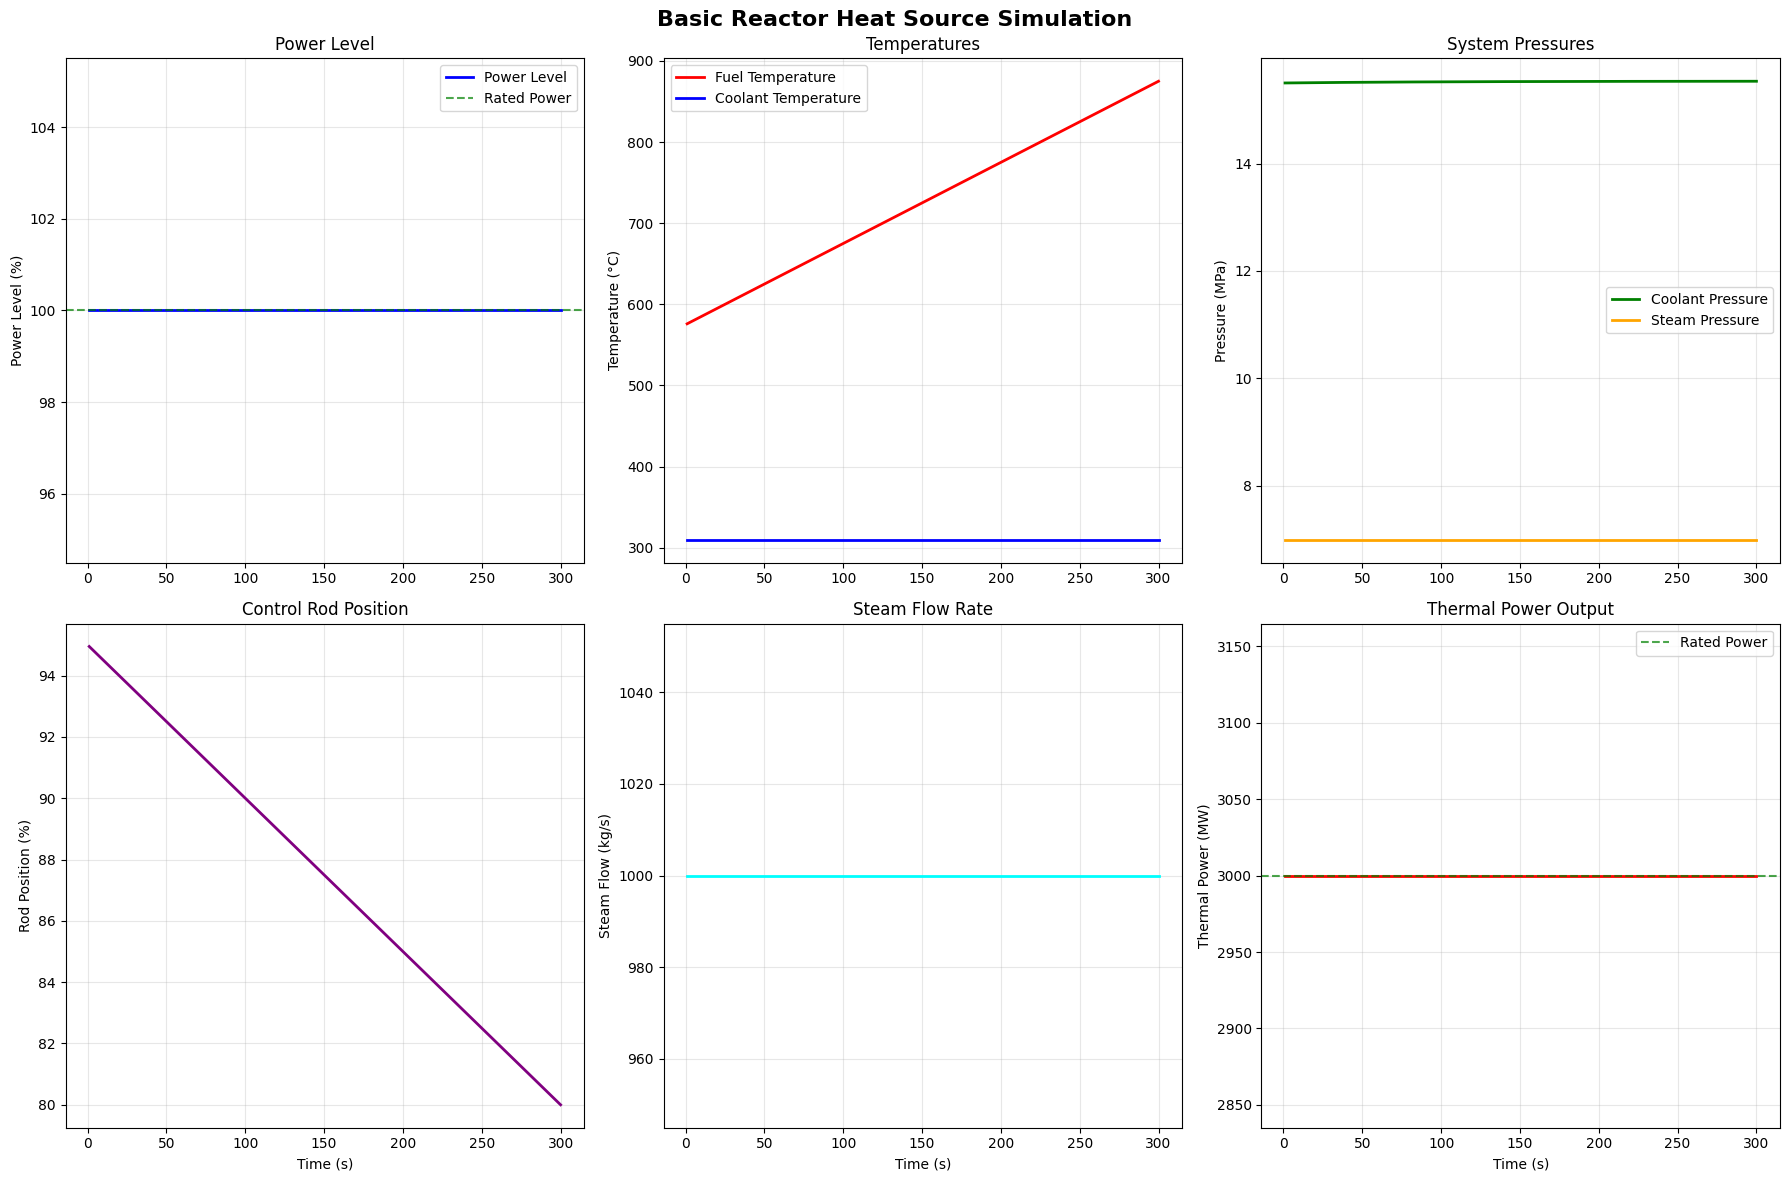

In [29]:
def plot_simulation_results(data: pd.DataFrame, title: str = "Nuclear Plant Simulation Results"):
    """
    Plot simulation results in a comprehensive dashboard
    """
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    fig.suptitle(title, fontsize=16, fontweight='bold')
    
    # Power Level
    axes[0, 0].plot(data['time'], data['power_level'], 'b-', linewidth=2, label='Power Level')
    axes[0, 0].axhline(y=100, color='g', linestyle='--', alpha=0.7, label='Rated Power')
    axes[0, 0].set_ylabel('Power Level (%)')
    axes[0, 0].set_title('Power Level')
    axes[0, 0].grid(True, alpha=0.3)
    axes[0, 0].legend()
    
    # Temperatures
    axes[0, 1].plot(data['time'], data['fuel_temperature'], 'r-', linewidth=2, label='Fuel Temperature')
    axes[0, 1].plot(data['time'], data['coolant_temperature'], 'b-', linewidth=2, label='Coolant Temperature')
    axes[0, 1].set_ylabel('Temperature (°C)')
    axes[0, 1].set_title('Temperatures')
    axes[0, 1].grid(True, alpha=0.3)
    axes[0, 1].legend()
    
    # Pressure
    axes[0, 2].plot(data['time'], data['coolant_pressure'], 'g-', linewidth=2, label='Coolant Pressure')
    axes[0, 2].plot(data['time'], data['steam_pressure'], 'orange', linewidth=2, label='Steam Pressure')
    axes[0, 2].set_ylabel('Pressure (MPa)')
    axes[0, 2].set_title('System Pressures')
    axes[0, 2].grid(True, alpha=0.3)
    axes[0, 2].legend()
    
    # Control Rod Position
    axes[1, 0].plot(data['time'], data['control_rod_position'], 'purple', linewidth=2)
    axes[1, 0].set_ylabel('Rod Position (%)')
    axes[1, 0].set_xlabel('Time (s)')
    axes[1, 0].set_title('Control Rod Position')
    axes[1, 0].grid(True, alpha=0.3)
    
    # Steam Flow Rate
    axes[1, 1].plot(data['time'], data['steam_flow_rate'], 'cyan', linewidth=2)
    axes[1, 1].set_ylabel('Steam Flow (kg/s)')
    axes[1, 1].set_xlabel('Time (s)')
    axes[1, 1].set_title('Steam Flow Rate')
    axes[1, 1].grid(True, alpha=0.3)
    
    # Thermal Power
    axes[1, 2].plot(data['time'], data['thermal_power_mw'], 'red', linewidth=2)
    axes[1, 2].axhline(y=3000, color='g', linestyle='--', alpha=0.7, label='Rated Power')
    axes[1, 2].set_ylabel('Thermal Power (MW)')
    axes[1, 2].set_xlabel('Time (s)')
    axes[1, 2].set_title('Thermal Power Output')
    axes[1, 2].grid(True, alpha=0.3)
    axes[1, 2].legend()
    
    plt.tight_layout()
    plt.show()

# Plot the basic results
plot_simulation_results(basic_data, "Basic Reactor Heat Source Simulation")

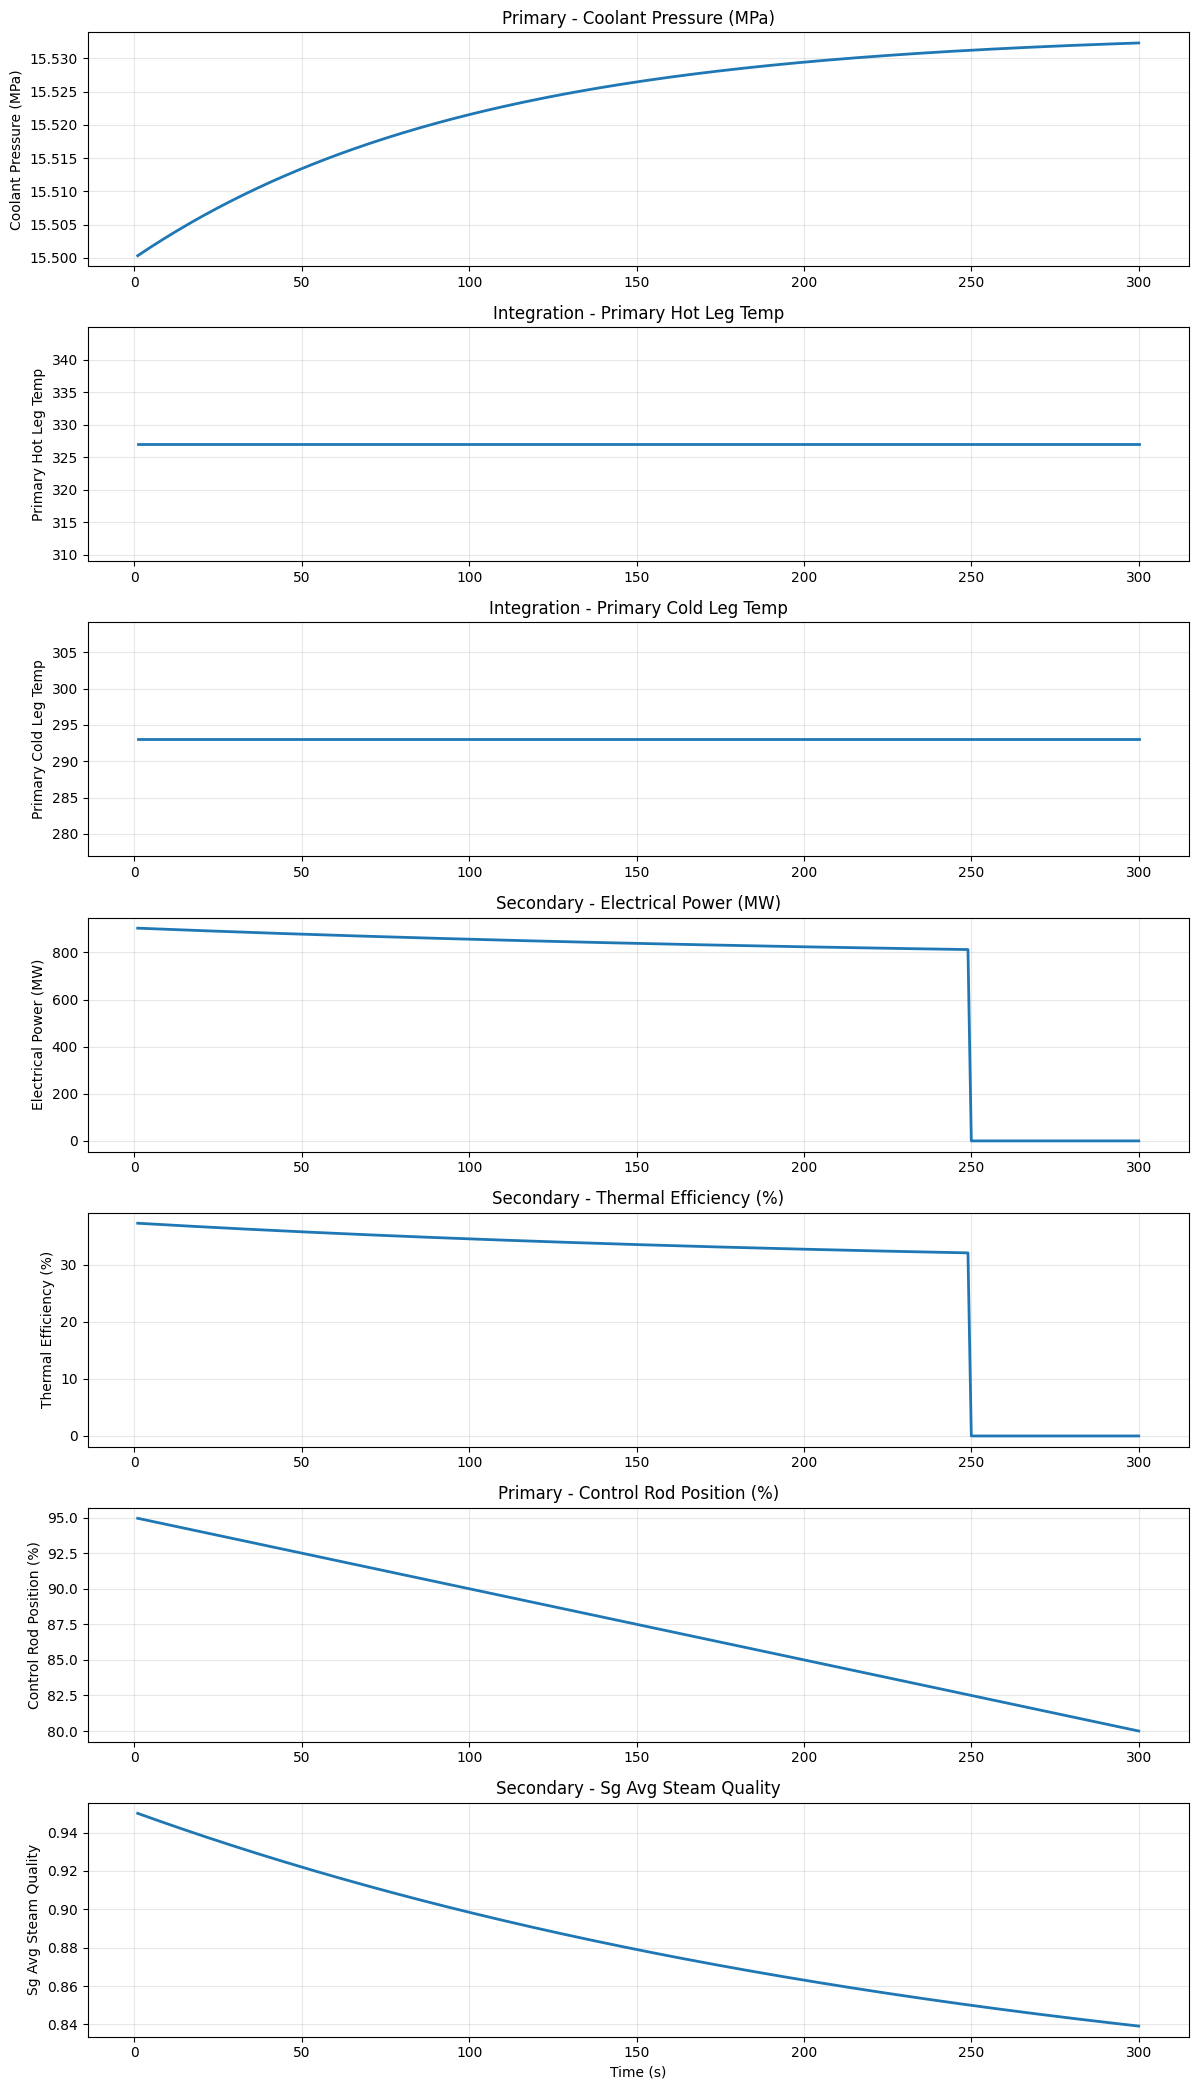

In [30]:
simulator.plot_parameters(['primary.coolant_pressure', 'integration.primary_hot_leg_temp', 'integration.primary_cold_leg_temp',
                           'secondary.electrical_power', 'secondary.thermal_efficiency', 'primary.control_rod_position',
                           'secondary.sg_avg_steam_quality'])